In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.datacollection import DataCollector

from tqdm import tqdm

from model import CrowdModel
from mesa.batchrunner import batch_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from SALib.sample import saltelli
from SALib.analyze import sobol


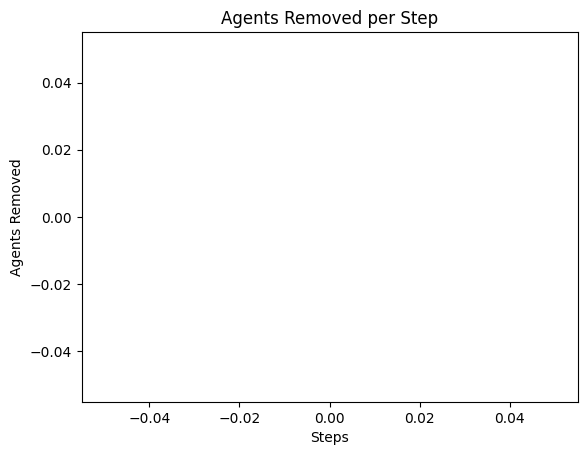

In [2]:
# Load the data from the CSV file
data = pd.read_csv("agents_removed_per_step.csv")

# prepare the data for plotting
steps = np.linspace(0, len(data), len(data))

# visualize the data
plt.plot(steps, data["Agents Removed"])
plt.xlabel("Steps")
plt.ylabel("Agents Removed")
plt.title("Agents Removed per Step")
plt.show()

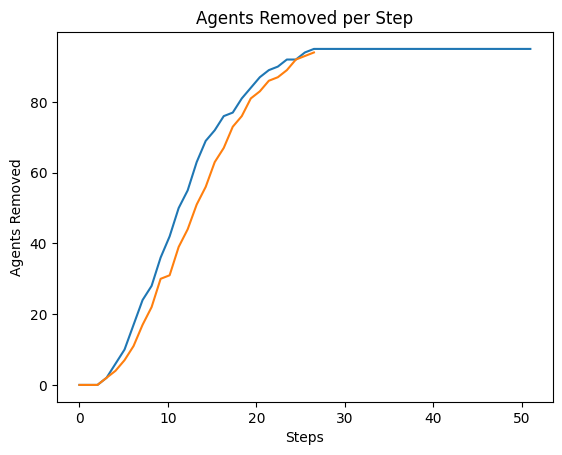

In [3]:
# Load the data from the CSV file
data = pd.read_csv("agents_removed_per_step_all_runs.csv")

for i in range(len(data.columns)):
    # prepare the data for plotting taking column i
    steps = np.linspace(0, len(data.iloc[:, i]), len(data.iloc[:, i]))

    # visualize the data
    plt.plot(steps, data.iloc[:, i])

plt.xlabel("Steps")
plt.ylabel("Agents Removed")
plt.title("Agents Removed per Step")
    
plt.show()

In [4]:
# add that main exit is different from emergency exits

dimension = 25

def scaling_factor(fraction, dimension):
    return int(np.sqrt((fraction * dimension**2)/np.pi))

# Define the parameter bounds for sensitivity analysis
parameter_bounds = {
    "social_radius": range(0, scaling_factor((1/6), dimension)),  # Vary social radius from 2 to 5
    "fire_radius": range(0, dimension),  # Vary fire radius from 5 to 10
    "exit_radius": range(0, dimension),  # Vary exit radius from 5 to 15
    "p_spreading": np.arange(0, 1.1, 0.1),  # Vary spreading probability from 0.1 to 0.5
    "p_spreading_environment": np.arange(0, 1.1, 0.1)  # Vary environment knowledge spreading probability from 0.1 to 0.5
}

# Define fixed parameters
fixed_params = {
    "width": dimension,
    "height": dimension,
    "N": int(0.25 * dimension * dimension),  # 25% of the grid size
    "p_env_knowledge_params": [3/25, 17/25]
}

# Function to adjust exits based on radius
def get_exits_with_radius(radius):
    return [
        {"location": (0, 24), "radius": radius},
        {"location": (24, 0), "radius": radius},
        {"location": (24, 24), "radius": radius}
    ]

# Run the sensitivity analysis for each parameter
def run_sensitivity_analysis():
    all_results = []
    
    for param, values in parameter_bounds.items():
        print(f"Running simulations for parameter: {param}")
        
        for value in values:
            # Create the parameter set for the current run
            param_set = {
                "social_radius": 4,  # Default value, can be adjusted
                "fire_radius": 7,    # Default value, can be adjusted
                "exits": get_exits_with_radius(10),  # Default value, can be adjusted
                "p_spreading": 0.3,  # Default value, can be adjusted
                "p_spreading_environment": 0.3  # Default value, can be adjusted
            }
            
            # Update the parameter set with the current parameter and value
            if param == "exit_radius":
                param_set["exits"] = get_exits_with_radius(value)
            else:
                param_set[param] = value
            
            # Combine with fixed parameters
            param_set.update(fixed_params)
            
            # Convert param_set to a format suitable for batch_run
            param_dict = {k: [v] for k, v in param_set.items()}
            
            # Run the batch
            try:
                results = batch_run(
                    model_cls=CrowdModel,
                    parameters=param_dict,
                    number_processes=None,  # Use all available processors
                    iterations=30,  # Number of iterations per parameter set
                    max_steps=700,  # Max steps for each run
                    data_collection_period=-1,  # Collect data at each step
                    display_progress=True  # Display progress bar
                )
            except Exception as e:
                print(f"Error during batch_run for {param} = {value}: {e}")
                continue

            # Convert results to a DataFrame
            results_df = pd.DataFrame(results)
            
            # Include the parameter name and value in the results
            results_df['parameter'] = param
            results_df['value'] = value
            
            # Append to all results
            all_results.append(results_df)
    
    # Combine all results into a single DataFrame
    combined_results = pd.concat(all_results, ignore_index=True)
    return combined_results

# Ensure this code runs only when executed as a script, not when imported as a module
if __name__ == "__main__":
    # Run the simulation and collect data
    results_df = run_sensitivity_analysis()

    # Save the results to a CSV file
    results_df.to_csv("sensitivity_analysis_results.csv", index=False)

    print("Sensitivity analysis completed and results saved to sensitivity_analysis_results.csv!")

Running simulations for parameter: social_radius


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

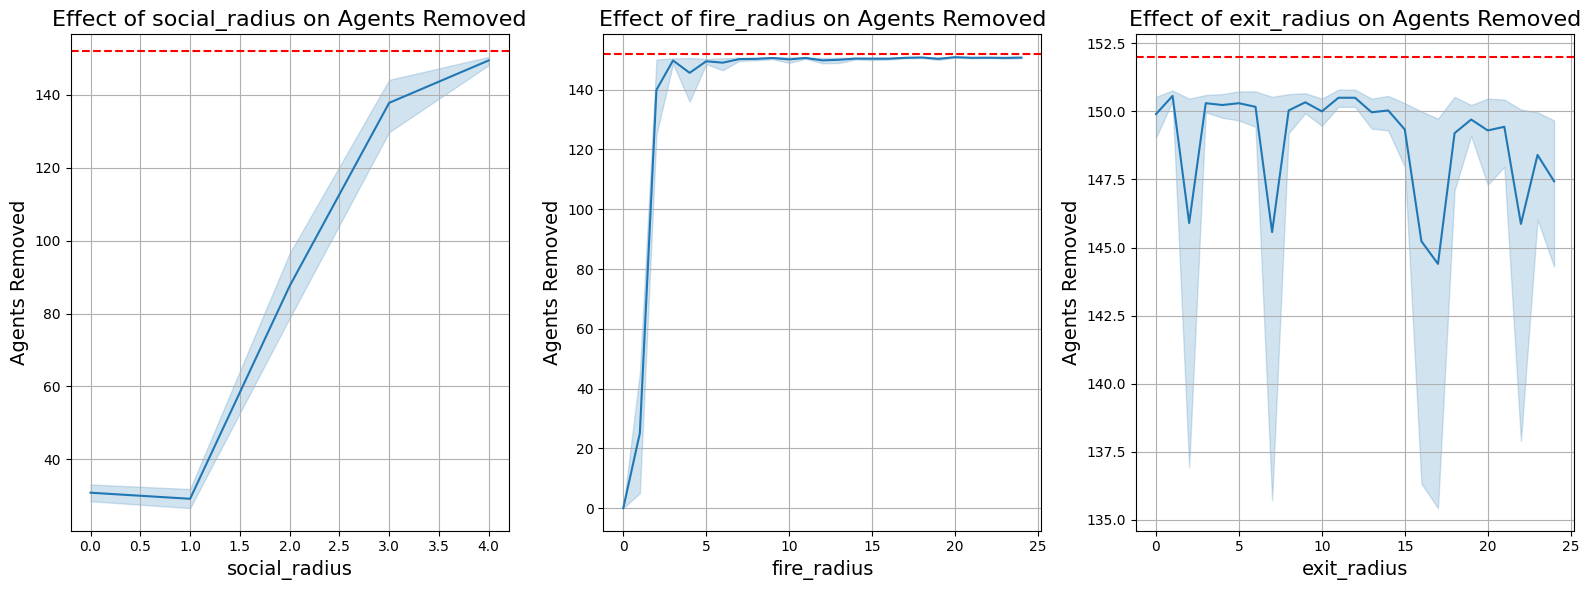

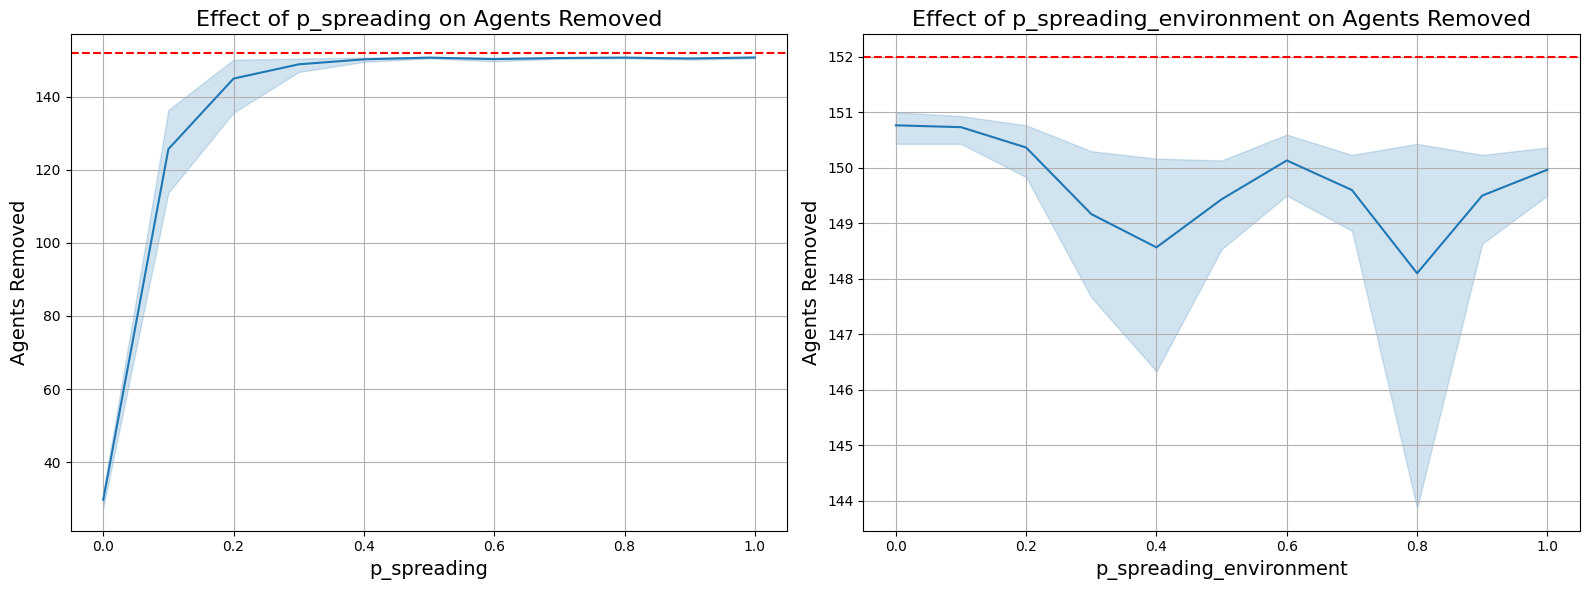

In [13]:
df = pd.read_csv('sensitivity_analysis_results.csv')

# Filter out the relevant columns
relevant_cols = ['parameter', 'value', 'Agents Removed']
df = df[relevant_cols]

# Group by parameter and calculate statistics
parameter_stats = df.groupby('parameter').agg({
    'value': 'first', 
    'Agents Removed': ['mean', 'median', 'std', 'min', 'max']
}).reset_index()

def plot_parameter_effects(num_of_plots, name_of_vars):
    """
    Plots the effects of two parameters on the 'Agents Removed' metric side by side.
    """
    
    fig, axes = plt.subplots(1, num_of_plots, figsize=(16, 6))  # Create a grid of 1 row and 2 columns
    
    for i in range(len(name_of_vars)):
        # Plot for the first parameter
        sns.lineplot(ax=axes[i], x='value', y='Agents Removed', data=df[df['parameter'] == name_of_vars[i]])
        axes[i].set_title(f'Effect of {name_of_vars[i]} on Agents Removed', fontsize=16)
        axes[i].set_xlabel(f'{name_of_vars[i]}', fontsize=14)
        axes[i].set_ylabel('Agents Removed', fontsize=14)
        # plot horizontal line at y = 156
        axes[i].axhline(y=152, color='r', linestyle='--', label='Critical point')
        axes[i].grid(True)

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()

# Plot effects of 'social_radius' and 'fire_radius' and "exit_radius" side by side
plot_parameter_effects(3, ['social_radius', 'fire_radius', 'exit_radius'])

# Plot effects of 'p_spreading' and 'p_spreading_environment' side by side
plot_parameter_effects(2, ['p_spreading', 'p_spreading_environment'])


In [12]:
# Define the dimension of the grid
dimension = 25

# Function to calculate the scaling factor based on the dimension
def scaling_factor(fraction, dimension):
    return int(np.sqrt((fraction * dimension**2)/np.pi))

# Define the Sobol analysis problem
problem = {
    'num_vars': 5,
    'names': ['social_radius', 'fire_radius', 'exit_radius', 'p_spreading', 'p_spreading_environment'],
    'bounds': [
        [0, scaling_factor(1/6, dimension)],  # Social radius
        [0, dimension],  # Fire radius
        [0, dimension],  # Exit radius
        [0, 1.1],  # Probability of spreading
        [0, 1.1]   # Probability of spreading environment knowledge
    ]
}

# Fixed parameters for the model
fixed_params = {
    "width": dimension,
    "height": dimension,
    "N": int(0.25 * dimension * dimension),  # 25% of the grid size
    "p_env_knowledge_params": [3/25, 17/25]  # Example fixed parameter
}

# Function to adjust exits based on radius
def get_exits_with_radius(radius):
    return [
        {"location": (0, 24), "radius": int(radius)},  # Cast to int explicitly
        {"location": (24, 0), "radius": int(radius)},  # Cast to int explicitly
        {"location": (24, 24), "radius": int(radius)}  # Cast to int explicitly
    ]

# Run the sensitivity analysis using Saltelli sampling
def run_sobol_sensitivity_analysis():
    # Generate samples
    param_values = saltelli.sample(problem, 1024)  # 1024 is the nearest power of 2 greater than 1000

    all_results = []
    count = 0
    
    # Prepare DataFrame to store results
    data = pd.DataFrame(index=range(len(param_values)), 
                        columns=['social_radius', 'fire_radius', 'exit_radius', 'p_spreading', 'p_spreading_environment'])
    data['RunId'], data['Agents Removed'], data['Agents Know Fire'], data['Exit Knowledge Spread'], data['Change Goal'] = None, None, None, None, None

    for i, vals in enumerate(tqdm(param_values, desc="Running Simulations")):
        param_set = {
            "social_radius": int(vals[0]),  # Cast to int explicitly
            "fire_radius": int(vals[1]),  # Cast to int explicitly
            "exits": get_exits_with_radius(vals[2]),
            "p_spreading": vals[3],
            "p_spreading_environment": vals[4]
        }

        # Combine with fixed parameters
        param_set.update(fixed_params)
        
        # Convert param_set to a format suitable for batch_run
        param_dict = {k: [v] for k, v in param_set.items() if not isinstance(v, list)}
        param_dict['exits'] = [param_set['exits']]  # Ensure 'exits' is in a list of lists format
        param_dict['p_env_knowledge_params'] = [fixed_params['p_env_knowledge_params']]  # Ensure 'p_env_knowledge_params' is in a list of lists format
        
        # Run the batch
        try:
            results = batch_run(
                model_cls=CrowdModel,
                parameters=param_dict,
                number_processes=None,  # Use all available processors
                iterations=10,  # Number of iterations per parameter set
                max_steps=700,  # Max steps for each run
                data_collection_period=-1,  # Collect data at each step
                display_progress=False  # Display progress bar
            )
        except Exception as e:
            print(f"Error during batch_run for {param_set}: {e}")
            continue
        
        # Process results
        results_df = pd.DataFrame(results)
        
        # Extract the average of each measure over iterations
        mean_results = results_df[['Agents Removed', 'Agents Know Fire', 'Exit Knowledge Spread', 'Change Goal']].mean(axis=0)
        
        # Store results
        data.iloc[count, 0:5] = vals  # Parameter values
        data.iloc[count, 5] = mean_results.get('Agents Removed', None)  # Storing 'Agents Removed'
        data.iloc[count, 6] = mean_results.get('Agents Know Fire', None)  # Storing 'Agents Know Fire'
        data.iloc[count, 7] = mean_results.get('Exit Knowledge Spread', None)  # Storing 'Exit Knowledge Spread'
        data.iloc[count, 8] = mean_results.get('Change Goal', None)  # Storing 'Change Goal'
        
        count += 1
    
    # Combine all results into a single DataFrame
    return data

# Ensure this code runs only when executed as a script, not when imported as a module
if __name__ == "__main__":
    # Run the simulation and collect data
    results_df = run_sobol_sensitivity_analysis()

    # Save the results to a CSV file
    results_df.to_csv("sobol_sensitivity_analysis_results.csv", index=False)

    print("Sensitivity analysis completed and results saved to sobol_sensitivity_analysis_results.csv!")

    # Analyze the results using Sobol analysis
    Y = results_df['Agents Removed'].values  # Target variable for analysis
    Si = sobol.analyze(problem, Y)
    
    # Print Sobol indices
    print("Sobol Sensitivity Analysis Results:")
    print("First order indices:", Si['S1'])
    print("Total order indices:", Si['ST'])
    print("Second order indices:", Si['S2'])

    # Visualize Sobol indices
    plt.figure(figsize=(10, 6))
    plt.bar(problem['names'], Si['S1'], yerr=Si['S1_conf'], label='First order')
    plt.bar(problem['names'], Si['ST'], yerr=Si['ST_conf'], alpha=0.5, label='Total order')
    plt.xlabel('Parameters')
    plt.ylabel('Sensitivity Index')
    plt.title('Sobol Sensitivity Analysis')
    plt.legend()
    plt.tight_layout()
    plt.savefig('sobol_sensitivity_analysis_results.png')
    plt.show()

C:\Users\koenw\AppData\Local\Temp\ipykernel_29444\2826286513.py:40: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)  # 1024 is the nearest power of 2 greater than 1000
Running Simulations:   0%|          | 1/12288 [00:13<44:48:38, 13.13s/it]

Columns in results_df: Index(['RunId', 'iteration', 'Step', 'social_radius', 'fire_radius',
       'p_spreading', 'p_spreading_environment', 'width', 'height', 'N',
       'exits', 'p_env_knowledge_params', 'Agents Removed', 'Agents Know Fire',
       'Exit Knowledge Spread', 'Change Goal'],
      dtype='object')


Running Simulations:   0%|          | 2/12288 [00:19<31:42:00,  9.29s/it]

Columns in results_df: Index(['RunId', 'iteration', 'Step', 'social_radius', 'fire_radius',
       'p_spreading', 'p_spreading_environment', 'width', 'height', 'N',
       'exits', 'p_env_knowledge_params', 'Agents Removed', 'Agents Know Fire',
       'Exit Knowledge Spread', 'Change Goal'],
      dtype='object')


Running Simulations:   0%|          | 3/12288 [00:33<38:19:20, 11.23s/it]

Columns in results_df: Index(['RunId', 'iteration', 'Step', 'social_radius', 'fire_radius',
       'p_spreading', 'p_spreading_environment', 'width', 'height', 'N',
       'exits', 'p_env_knowledge_params', 'Agents Removed', 'Agents Know Fire',
       'Exit Knowledge Spread', 'Change Goal'],
      dtype='object')


Running Simulations:   0%|          | 3/12288 [00:43<49:50:29, 14.61s/it]


KeyboardInterrupt: 

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyze
import matplotlib.pyplot as plt
from mesa.batchrunner import batch_run  # Ensure you have the correct import for batch_run
from model import CrowdModel  # Replace with your actual module and model class
import logging
import os

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the dimension of the grid
dimension = 25

# Function to calculate the scaling factor based on the dimension
def scaling_factor(fraction, dimension):
    return int(np.sqrt((fraction * dimension**2)/np.pi))

# Define the Sobol analysis problem
problem = {
    'num_vars': 5,
    'names': ['social_radius', 'fire_radius', 'exit_radius', 'p_spreading', 'p_spreading_environment'],
    'bounds': [
        [0, scaling_factor(1/6, dimension)],  # Social radius
        [0, dimension],  # Fire radius
        [0, dimension],  # Exit radius
        [0, 1.1],  # Probability of spreading
        [0, 1.1]   # Probability of spreading environment knowledge
    ]
}

# Fixed parameters for the model
fixed_params = {
    "width": dimension,
    "height": dimension,
    "N": int(0.25 * dimension * dimension),  # 25% of the grid size
    "p_env_knowledge_params": [3/25, 17/25]  # Example fixed parameter
}

# Function to adjust exits based on radius
def get_exits_with_radius(radius):
    return [
        {"location": (0, 24), "radius": int(radius)},  # Cast to int explicitly
        {"location": (24, 0), "radius": int(radius)},  # Cast to int explicitly
        {"location": (24, 24), "radius": int(radius)}  # Cast to int explicitly
    ]

# Function to run a single batch of simulations
def run_single_batch(param_set, param_dict):
    try:
        pid = os.getpid()
        logging.info(f"Running batch with parameters: {param_set} on PID: {pid}")
        results = batch_run(
            model_cls=CrowdModel,
            parameters=param_dict,
            number_processes=None,  # Use all available processors
            iterations=10,  # Number of iterations per parameter set
            max_steps=700,  # Max steps for each run
            data_collection_period=-1,  # Collect data at each step
            display_progress=False  # Display progress bar
        )
        return results
    except Exception as e:
        logging.error(f"Error during batch_run for {param_set} on PID: {pid}: {e}")
        return None

# Run the sensitivity analysis using Sobol sampling
def run_sobol_sensitivity_analysis():
    # Generate samples
    param_values = sobol.sample(problem, 1024)  # Increased sample size for final analysis

    all_results = []
    
    # Prepare DataFrame to store results
    data = pd.DataFrame(index=range(len(param_values)), 
                        columns=['social_radius', 'fire_radius', 'exit_radius', 'p_spreading', 'p_spreading_environment'])
    data['RunId'], data['Agents Removed'], data['Agents Know Fire'], data['Exit Knowledge Spread'], data['Change Goal'] = None, None, None, None, None

    for i, vals in enumerate(tqdm(param_values, desc="Running Simulations")):
        param_set = {
            "social_radius": int(vals[0]),  # Cast to int explicitly
            "fire_radius": int(vals[1]),  # Cast to int explicitly
            "exits": get_exits_with_radius(vals[2]),
            "p_spreading": vals[3],
            "p_spreading_environment": vals[4]
        }

        # Combine with fixed parameters
        param_set.update(fixed_params)
        
        # Convert param_set to a format suitable for batch_run
        param_dict = {k: [v] for k, v in param_set.items() if not isinstance(v, list)}
        param_dict['exits'] = [param_set['exits']]  # Ensure 'exits' is in a list of lists format
        param_dict['p_env_knowledge_params'] = [fixed_params['p_env_knowledge_params']]  # Ensure 'p_env_knowledge_params' is in a list of lists format
        
        results = run_single_batch(param_set, param_dict)
        if results is not None:
            results_df = pd.DataFrame(results)
            
            # Extract the average of each measure over iterations
            mean_results = results_df[['Agents Removed', 'Agents Know Fire', 'Exit Knowledge Spread', 'Change Goal']].mean(axis=0)
            
            # Store results
            data.iloc[i, 0:5] = param_values[i]  # Parameter values
            data.iloc[i, 5] = mean_results.get('Agents Removed', None)  # Storing 'Agents Removed'
            data.iloc[i, 6] = mean_results.get('Agents Know Fire', None)  # Storing 'Agents Know Fire'
            data.iloc[i, 7] = mean_results.get('Exit Knowledge Spread', None)  # Storing 'Exit Knowledge Spread'
            data.iloc[i, 8] = mean_results.get('Change Goal', None)  # Storing 'Change Goal'

    return data

# Ensure this code runs only when executed as a script, not when imported as a module
if __name__ == "__main__":
    # Run the simulation and collect data
    results_df = run_sobol_sensitivity_analysis()

    # Save the results to a CSV file
    results_df.to_csv("sobol_sensitivity_analysis_results.csv", index=False)

    print("Sensitivity analysis completed and results saved to sobol_sensitivity_analysis_results.csv!")

    # Analyze the results using Sobol analysis with parallel processing
    Y = results_df['Agents Removed'].values  # Target variable for analysis
    Si = sobol_analyze(problem, Y, n_processors=4)  # Use 4 processors for parallel processing
    
    # Print Sobol indices
    print("Sobol Sensitivity Analysis Results:")
    print("First order indices:", Si['S1'])
    print("Total order indices:", Si['ST'])
    print("Second order indices:", Si['S2'])

    # Plot results for quick inspection
    plt.figure(figsize=(10, 6))
    plt.bar(problem['names'], Si['S1'], yerr=Si['S1_conf'], label='First order')
    plt.bar(problem['names'], Si['ST'], yerr=Si['ST_conf'], alpha=0.5, label='Total order')
    plt.xlabel('Parameters')
    plt.ylabel('Sensitivity Index')
    plt.title('Sobol Sensitivity Analysis')
    plt.legend()
    plt.tight_layout()
    plt.savefig('sobol_sensitivity_analysis_results.png')
    plt.show()


Running Simulations:   0%|          | 1/12288 [00:14<50:58:29, 14.94s/it]


KeyboardInterrupt: 